In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet169

from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import optimizers
from collections import Counter
import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model
from IPython.display import Image

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D

In [2]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR')
]

In [3]:
def Train_Val_Plot2(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,recall,val_recall,prc,val_prc):
    
    fig, (ax1, ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(recall) + 1), recall)
    ax5.plot(range(1, len(val_recall) + 1), val_auc)
    ax5.set_title('History of recall')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('recall')
    ax5.legend(['training', 'validation'])
    
    ax6.plot(range(1, len(prc) + 1), prc)
    ax6.plot(range(1, len(val_prc) + 1), val_prc)
    ax6.set_title('History of prc')
    ax6.set_xlabel('Epochs')
    ax6.set_ylabel('prc')
    ax6.legend(['training', 'validation'])
    
    recall,val_recall,prc,val_prc
    
#     ax5.plot(range(1, len(f1) + 1), f1)
#     ax5.plot(range(1, len(val_f1) + 1), val_f1)
#     ax5.set_title('History of F1-score')
#     ax5.set_xlabel('Epochs')
#     ax5.set_ylabel('F1 score')
#     ax5.legend(['training', 'validation'])


    plt.show()

In [4]:
def initDataGens():
    
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   rotation_range=0.3, #5,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   #zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode='nearest')

#     valid_datagen = ImageDataGenerator(rescale = 1./255,
#                                   validation_split = 0.2
#                                   )

    test_datagen  = ImageDataGenerator(rescale = 1./255)


    return train_datagen, test_datagen, test_datagen

In [5]:
def initDataSets(train, test, train_datagen, valid_datagen, test_datagen, classes_):
    
    train_dataset  = train_datagen.flow_from_directory(directory = train,#'../input/fer2013/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   classes=classes_,
                                                   subset = 'training',
                                                   batch_size = 64)

    valid_dataset = train_datagen.flow_from_directory(directory = train,#'../input/fer2013/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  classes=classes_,
                                                  subset = 'validation',
                                                  batch_size = 64)
    
#     valid_dataset = valid_datagen.flow_from_directory(directory = train,#'../input/fer2013/train',
#                                                   target_size = (48,48),
#                                                   class_mode = 'categorical',
#                                                   classes=classes_,
#                                                   subset = 'validation',
#                                                   batch_size = 64)

    test_dataset = test_datagen.flow_from_directory(directory = test, #'../input/fer2013/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  classes=classes_,
                                                  batch_size = 64)


    return train_dataset, valid_dataset, test_dataset

In [6]:
def updateBaseModel(base_model, num_classes):
    
    for layer in base_model.layers[:]:
        layer.trainable=True
    
    # Building Model
    model=Sequential()
    model.add(base_model)
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(32,kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32,kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32,kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [7]:
def plot_DG(data_generator):
    counter = Counter(data_generator.classes)
    data_items = counter.items() # dict_items([(0, 1648), (1, 3614)])
    l = list(counter.items())
    print(l)
#     pd.DataFrame(l, columns=['class','count']).set_index('class').plot(kind='bar', colormap='Set2');
    
    plt.bar(range(len(l)), [val[1] for val in l], align='center')
    plt.xticks(range(len(l)), [val[0] for val in l])
    plt.xticks(rotation=70)
    plt.show()
    
#     df = pd.DataFrame(l, columns=['index', 'observers'])
#     print(df)
# ['Anger', 'Disgust', 'Fear', 'Happy','Neutral','Sad', 'Surprise']

In [8]:
def getClassWeights(train_dataset):
    
    counter = Counter(train_dataset.classes)                          
    max_val = float(max(counter.values()))       
    class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}    
    print(class_weights)

    return class_weights

In [10]:
def getAllForTraining(model, save_h5_to_path, epochs_):
    
    lrd = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1,
    )

    mcp_5categories = ModelCheckpoint(save_h5_to_path)

    # es = EarlyStopping(verbose=1, patience=20)
#     es = EarlyStopping(
#         monitor='val_accuracy',
#         min_delta=0.00005,
#         patience=11,
#         verbose=1,
#         restore_best_weights=True,
#     )

    # optimizers.Adam(learning_rate=1e-3, decay=1e-3 / epochs)
    # model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)
    t_epochs = epochs_

    optim = optimizers.Adam(learning_rate=1e-3, decay=1e-3 / t_epochs)
    model.compile(optimizer=optim, loss='categorical_crossentropy',metrics=METRICS)
    model.summary()

#     return lrd, mcp_5categories, es, t_epochs, model, t_epochs
    return lrd, mcp_5categories, t_epochs, model, t_epochs

In [11]:
def plotConfusionMatrix(model, test_dataset, num_of_test_samples, batch_size, target_names):
    
    #Confution Matrix and Classification Report
    Y_pred = model.predict(test_dataset, num_of_test_samples // batch_size+1)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    cm = confusion_matrix(test_dataset.classes, y_pred)
    print('Classification Report')
    print(classification_report(test_dataset.classes, y_pred, target_names=target_names))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

Found 18603 images belonging to 7 classes.
Found 4648 images belonging to 7 classes.
Found 5772 images belonging to 7 classes.
{0: 1.0184766214177978, 1: 1.0025983667409057, 2: 1.0089652596189764, 3: 1.012368815592204, 4: 1.0, 5: 1.057556773688332, 6: 1.0165600301091458}
[(0, 2652), (1, 2694), (2, 2677), (3, 2668), (4, 2701), (5, 2554), (6, 2657)]


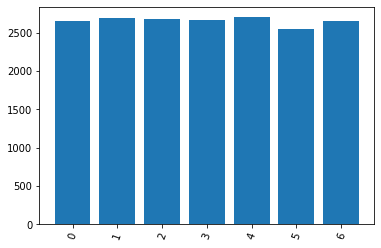

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1, 1, 1024)        3228864   
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense (Dense)                (None, 32)                32800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0

In [12]:
# 7 emotions

target_names = ['Anger','Disgust','Fear','Happy','Neutral','Sad','Surprise']
num_classes = len(target_names)
train_path = './fer2013pluscleanedaugmballanced1/train'
test_path = './fer2013pluscleanedaugmballanced1/test'
save_model_h5_to_path = 'MobileNet-Classification-7emotions-CNN.h5'
epochs = 100

train_datagen, valid_datagen, test_datagen = initDataGens()
train_dataset, valid_dataset, test_dataset = initDataSets(train_path, test_path, train_datagen, valid_datagen, test_datagen, target_names)
class_weights = getClassWeights(train_dataset)
plot_DG(train_dataset)

# base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")
base_model = tf.keras.applications.MobileNet(input_shape=(48,48,3),include_top=False,weights="imagenet")

# model = build_net(optimizers.SGD(learning_rate=0.01, momentum=0.9), 7, METRICS)

model = updateBaseModel(base_model, len(target_names))
lrd, mcp_5categories, t_epochs, model, t_epochs = getAllForTraining(model, save_model_h5_to_path, epochs)

In [13]:
# history1 = model.fit(train_dataset,validation_data=valid_dataset,epochs = 200,verbose = 1,callbacks=[lrd,mcp_5categories,es], class_weight=class_weights)
history1 = model.fit(train_dataset,validation_data=valid_dataset,epochs = 100,verbose = 1,callbacks=[lrd,mcp_5categories], class_weight=class_weights)

Epoch 1/100
291/291 [==============================] - 27s 61ms/step - loss: 1.9090 - tp: 655.0000 - fp: 538.0000 - tn: 111080.0000 - fn: 17948.0000 - accuracy: 0.8580 - precision: 0.5490 - recall: 0.0352 - auc: 0.6286 - prc: 0.2387 - val_loss: 1.5652 - val_tp: 172.0000 - val_fp: 10.0000 - val_tn: 27878.0000 - val_fn: 4476.0000 - val_accuracy: 0.8621 - val_precision: 0.9451 - val_recall: 0.0370 - val_auc: 0.8039 - val_prc: 0.4744
Epoch 2/100
291/291 [==============================] - 13s 45ms/step - loss: 1.5564 - tp: 2691.0000 - fp: 946.0000 - tn: 110672.0000 - fn: 15912.0000 - accuracy: 0.8705 - precision: 0.7399 - recall: 0.1447 - auc: 0.7900 - prc: 0.4388 - val_loss: 1.1743 - val_tp: 1555.0000 - val_fp: 319.0000 - val_tn: 27569.0000 - val_fn: 3093.0000 - val_accuracy: 0.8951 - val_precision: 0.8298 - val_recall: 0.3346 - val_auc: 0.8915 - val_prc: 0.6477
Epoch 3/100
291/291 [==============================] - 13s 45ms/step - loss: 1.3765 - tp: 4490.0000 - fp: 1363.0000 - tn: 110255.

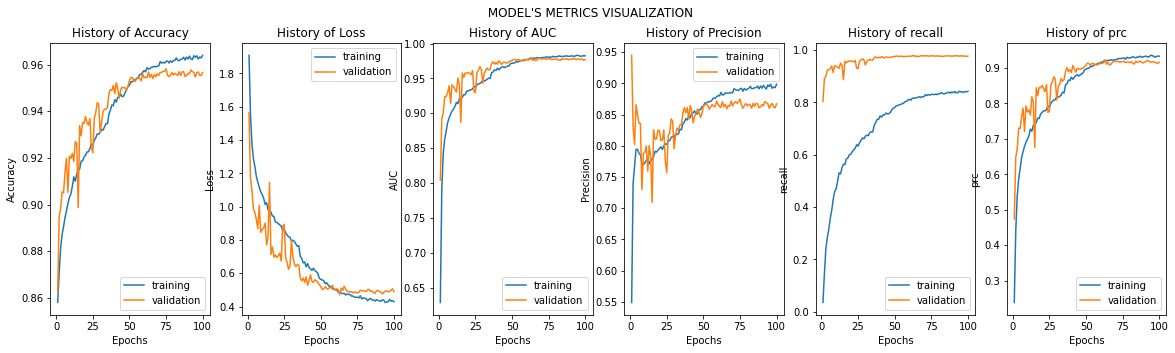

In [14]:
Train_Val_Plot2(history1.history['accuracy'],history1.history['val_accuracy'],
               history1.history['loss'],history1.history['val_loss'],
               history1.history['auc'],history1.history['val_auc'],
               history1.history['precision'],history1.history['val_precision'],
               history1.history['recall'],history1.history['val_recall'],
               history1.history['prc'],history1.history['val_prc']
              )

In [16]:
model.save("model1.h5")

In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model('model1.h5')